## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch

import os

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from fastai.conv_learner import *

from sklearn.metrics import fbeta_score

In [78]:
from pdb import set_trace

For this experiment the dataset used is in folder images_002_resize

### Looking at labels

In [2]:
labels = pd.read_csv('data/nih/labels_002_mlabel.csv')

In [3]:
labels.shape

(10000, 2)

Multiple pathology has been separated by space

In [4]:
labels.head()

,image_id,pathology
0,00001336_000.png,No_Finding
1,00001337_000.png,No_Finding
2,00001338_000.png,No_Finding
3,00001338_001.png,No_Finding
4,00001338_002.png,Infiltration


In [5]:
#path to label file
label_csv = 'data/nih/labels_002_mlabel.csv'

## Multi-label models for X-ray dataset

Custom metric for multi-label

In [6]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

Custom loss function

In [7]:
i = V(F.sigmoid(torch.randn(3,4)),requires_grad=True).cuda()

In [8]:
i

Variable containing:
 0.6691  0.3932  0.3884  0.7868
 0.1838  0.5155  0.8009  0.6825
 0.3584  0.1874  0.4627  0.3552
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

In [9]:
t = V(torch.FloatTensor(3,4).random_(2),requires_grad=True).cuda()

In [10]:
t

Variable containing:
 1  0  0  0
 0  1  0  0
 1  0  1  1
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

In [11]:
class_wgt = V(torch.FloatTensor(1,15))

In [12]:
class_wgt.requires_grad

False

In [13]:
class_wgt = V(class_wgt.view(-1,4))

RuntimeError: invalid argument 2: size '[-1 x 4]' is invalid for input with 15 elements at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/TH/THStorage.c:37

In [14]:
class_wgt

Variable containing:

Columns 0 to 5 
-1.0115e+09  4.5668e-41 -1.0115e+09  4.5668e-41  1.3593e-43  4.4842e-44

Columns 6 to 11 
 1.4013e-43  1.4714e-43  1.5975e-43  1.4153e-43  1.3873e-43  1.6255e-43

Columns 12 to 14 
 1.5554e-43  1.5975e-43  1.6956e-43
[torch.cuda.FloatTensor of size 1x15 (GPU 0)]

In [15]:
-torch.mul(i,t)

Variable containing:
-0.6691 -0.0000 -0.0000 -0.0000
-0.0000 -0.5155 -0.0000 -0.0000
-0.3584 -0.0000 -0.4627 -0.3552
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

In [16]:
torch.mean(torch.mean(-torch.mul(class_wgt,torch.mul(i,t))-torch.mul(1-class_wgt,torch.mul(1-i,1-t)),dim=1))

RuntimeError: The size of tensor a (15) must match the size of tensor b (4) at non-singleton dimension 1

In [17]:
torch.sum(torch.mean(z, dim = 1))/3

NameError: name 'z' is not defined

In [112]:
def wt_binary_cross_entropy(y_pred,y_true):
#     set_trace()
    class_wgt = V(torch.FloatTensor(1-np.sum(data.trn_ds.y,axis=0)/8000).view(-1,15))
    return torch.mean(torch.mean(-torch.mul(class_wgt, torch.mul(torch.log(y_pred), y_true))-torch.mul(1 - class_wgt, torch.mul(torch.log(1 -y_pred), 1 - y_true)),dim=1))

In [81]:
metrics=[f2]
f_model = resnet34

In [82]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n,seed = 4) #fastai fn

In [83]:
val_idxs.shape

(2000,)

In [84]:
PATH = 'data/nih/'

In [85]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, max_zoom=1.0)
    return ImageClassifierData.from_csv(
        PATH, 'images_002_resize', label_csv, tfms=tfms, val_idxs=val_idxs)

In [86]:
data = get_data(300)

In [87]:
x,y = next(iter(data.val_dl))

In [88]:
x.shape

torch.Size([64, 3, 300, 300])

In [89]:
data.classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No_Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

Looking at a particular image label

In [90]:
list(zip(data.classes, y[2]))

[('Atelectasis', 0.0),
 ('Cardiomegaly', 0.0),
 ('Consolidation', 0.0),
 ('Edema', 0.0),
 ('Effusion', 0.0),
 ('Emphysema', 0.0),
 ('Fibrosis', 0.0),
 ('Hernia', 0.0),
 ('Infiltration', 1.0),
 ('Mass', 0.0),
 ('No_Finding', 0.0),
 ('Nodule', 0.0),
 ('Pleural_Thickening', 0.0),
 ('Pneumonia', 0.0),
 ('Pneumothorax', 0.0)]

This X-ray has infiltration

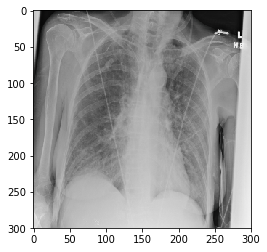

In [91]:
plt.imshow(data.val_ds.denorm(to_np(x))[2]);

In [92]:
sz=256

In [93]:
data = get_data(sz)

In [94]:
# data = data.resize(int(sz*1.3), 'tmp')

In [108]:
learn = ConvLearner.pretrained(f_model, data,metrics = metrics)

In [114]:
learn.crit = wt_binary_cross_entropy

In [115]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

RuntimeError: value cannot be converted to type double without overflow: inf

In [116]:
%debug


> <ipython-input-112-19c526ecf798>(4)wt_binary_cross_entropy()
      1 def wt_binary_cross_entropy(y_pred,y_true):
      2 #     set_trace()
      3     class_wgt = V(torch.FloatTensor(1-np.sum(data.trn_ds.y,axis=0)/8000).view(-1,15))
----> 4     return torch.mean(torch.mean(-torch.mul(class_wgt, torch.mul(torch.log(y_pred), y_true))-torch.mul(1 - class_wgt, torch.mul(torch.log(1 -y_pred), 1 - y_true)),dim=1))

ipdb> 
ipdb> q


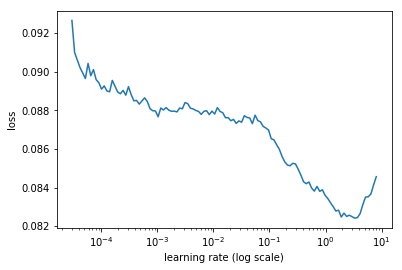

In [117]:
learn.sched.plot(n_skip_end=1)

In [118]:
lr = 0.1

In [119]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  4%|▍         | 5/125 [00:06<02:33,  1.28s/it, loss=0.11] 


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f2                           
    0      0.096342   0.081665   0.313576  
    1      0.084397   0.074115   0.318836                     
    2      0.077833   0.072978   0.32052                      
    3      0.074913   0.070753   0.325427                     
    4      0.071421   0.070085   0.332649                     
    5      0.069774   0.069616   0.329877                     
    6      0.068384   0.069518   0.329799                     



[0.06951775, 0.3297993129016821]

In [57]:
lrs = np.array([lr/9,lr/3,lr])

In [58]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.187532   0.180004   0.64942   
    1      0.176968   0.176755   0.654686                    
    2      0.15687    0.175893   0.654769                    
    3      0.161112   0.179055   0.651846                    
    4      0.137352   0.192262   0.625105                    
    5      0.102727   0.200404   0.597014                    
    6      0.081459   0.20359    0.604575                     



[0.20359018, 0.6045754147520161]

In [59]:
learn.save('m1')

In [60]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.193109   3.151663   0.590924  



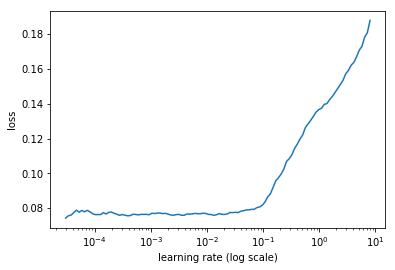

In [62]:
learn.sched.plot(n_skip_end=1)

In [63]:
lr = .01

In [64]:
lrs = np.array([lr/9,lr/3,lr])

In [65]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.077118   0.206808   0.607438  
    1      0.073029   0.210221   0.585114                     
    2      0.068824   0.212233   0.59558                      
    3      0.067875   0.217292   0.580117                     
    4      0.064506   0.222566   0.591524                     
    5      0.0604     0.222257   0.580068                     
    6      0.059598   0.225951   0.58692                      



[0.22595097, 0.5869202444892085]

In [20]:
sz=128

In [21]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [120]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [122]:
preds

array([[0.84159, 0.33498, 0.44926, ..., 0.2253 , 0.51088, 0.08608],
       [0.041  , 0.11492, 0.36796, ..., 0.64768, 0.48792, 0.33205],
       [0.36487, 0.67603, 0.26898, ..., 0.57904, 0.32148, 0.37266],
       ...,
       [0.50267, 0.49464, 0.52841, ..., 0.3456 , 0.65602, 0.61446],
       [0.64984, 0.24803, 0.59115, ..., 0.38921, 0.53592, 0.50898],
       [0.85907, 0.44529, 0.70856, ..., 0.52589, 0.50705, 0.61459]], dtype=float32)

In [31]:
from sklearn.metrics import f1_score

In [34]:
y.shape

(2000, 15)

In [26]:
from sklearn.metrics import roc_auc_score

In [41]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [125]:
np.sum(preds>0.5,axis=0)

array([ 738,  731,  638,  642,  672,  678,  757,  940,  703,  698, 1089,  728,  895,  819,  669])

In [126]:
np.sum(y, axis = 0)

array([ 188.,   32.,   66.,   19.,  165.,   36.,   43.,    2.,  266.,   67., 1209.,  102.,   62.,   31.,
         91.], dtype=float32)

In [123]:
f2(preds,y)

0.3288489831865372

In [124]:
preds>

array([[0.84159, 0.33498, 0.44926, ..., 0.2253 , 0.51088, 0.08608],
       [0.041  , 0.11492, 0.36796, ..., 0.64768, 0.48792, 0.33205],
       [0.36487, 0.67603, 0.26898, ..., 0.57904, 0.32148, 0.37266],
       ...,
       [0.50267, 0.49464, 0.52841, ..., 0.3456 , 0.65602, 0.61446],
       [0.64984, 0.24803, 0.59115, ..., 0.38921, 0.53592, 0.50898],
       [0.85907, 0.44529, 0.70856, ..., 0.52589, 0.50705, 0.61459]], dtype=float32)

### End